<table style="width:100%">
  <tr>
    <td><img alt="Departamento de Matemáticas, Estadística e Invest. Operativa" src="EIO_ULL_logo.png" width="500" href="https://www.ull.es/departamentos/matematicas-estadistica-e-investigacion-operativa/"></td> 
    <td><img alt="Biostatnet" src="biostatnet_logo.png" width="500" href="https://biostatnet.com/"></td> 
  </tr> 
</table>

# Predictive modelling of 2019-nCov outbreak data in Canary Islands
#### Authors:  Carlos J. Pérez González, Arturo J. Fernández Rodríguez and Roberto Dorta Guerra

*   [1. Introduction](#intro)
*   [2. Loading required libraries](#libraries)
*   [3. Data source](#source)
*   [3.1 Read and arrange data](#read)
*   [4. Fitting model to data](#fit)
*   [4.1 Making predictions](#predict)
*   [4.2 Table and plot of observed and predicted data](#plot)
*   [4.3 Predicting the hospitalized patients](#hospitalized)
*   [5. How to cite this work](#cite)
*   [6. References](#references)

<a id='intro'></a>
## 1. Introduction

We provide the current notebook to present the predictive models for the number of infected people and hospitalized patients in the COVID-19 outbreak.




<a id='libraries'></a>
## 2. Loading required libraries

The following are the required libraries to perform the diferent data analysis and prediction modelling.

In [1]:
load_libraries<-function(packages) {
    suppressWarnings(invisible(lapply(packages, library, character.only = TRUE)))
}

load_libraries(c("dplyr","tidyr","reshape2","ggplot2","drc","gridExtra"))


<a id='source'></a>
## 3. Data source

In this notebook we process data including the total of confirmed cases, the hospitalized pacients and the hospitalized with severe Covid-19 admitted to the intensive care unit (ICU) by autonomous community since outbreak start in Spain. These data are obtained from [Datadista COVID19 Github repository](https://github.com/datadista/datasets/tree/master/COVID%2019). 

**IMPORTANTE** Data in Datadista repository contains the publication date by Ministerio de Sanidad of data consolidated at 21:00 (UTC+2) of previous day. 

<a id='read'></a>
### 3.1 Read and arrange data

The function *read_from_github()* read data from Github repo (we have selected the tables with the number of confirmed cases, recovered patients, death toll as well as the hospitalized patients and hospitalized in ICUs) and arrange them in an appropriate way for fitting and prediction. We have created another function *filter_ccaa_data()* to filter data by CCAA and replace NA values in the different variables.

In [2]:
#Function to read and arragen data from GitHub
read_from_github<-function(table_name) {
  tryCatch({
    data<-suppressMessages(readr::read_csv(sprintf("https://raw.githubusercontent.com/datadista/datasets/master/COVID%%2019/ccaa_covid19_%s.csv",table_name)))
    data<-data %>% unnest() %>% data.frame(stringsAsFactors = FALSE)
    data<-data %>% melt(id = c("cod_ine","CCAA")) %>% arrange(CCAA) %>% 
      dplyr::rename(date_ref=variable) %>% 
      mutate(date=as.Date(gsub("\\.","/",substring(as.character(date_ref),2)),format="%Y/%m/%d")-1) %>%
      mutate(date_public=gsub("X","",as.character(date_ref))) %>%
      dplyr::select(cod_ine,CCAA,date_public,date,value) %>%
      dplyr::rename(ccaa=CCAA)
    message(sprintf("File ccaa_covid19_%s.csv read succesfully.",table_name))
    return(data)
  }, error = function(error_condition) {
    message(sprintf("File ccaa_covid19_%s.csv read failed.",table_name))
    message(error_message)
    return(NA)
    })
}


#Function to filter a given CCAA
filter_ccaa_data<-function(data, name_ccaa) {
  data_can<-data %>% filter(ccaa==name_ccaa & var %in% c("casos","altas","fallecidos","uci","hospitalizados")) 
 
  data_can<-reshape2::dcast(data_can, cod_ine+ccaa+date_public+date~var) %>% 
    arrange(date) %>% mutate(casos=ifelse(is.na(casos),0,casos),
                             altas=ifelse(is.na(altas),0,altas))
  
  data_can<-data_can %>% mutate(fallecidos=ifelse(date<max(date[fallecidos==0],na.rm = TRUE),0,fallecidos),
                                  uci=ifelse(date<max(date[uci==0],na.rm = TRUE),0,uci))
  data_can
}

Firstly, we create a full *data.frame* with the different variables of interest.

In [3]:
table_name <- "casos"
covid_full_data <- read_from_github(table_name) 
template_data <-covid_full_data %>% dplyr::select(cod_ine,ccaa,date_public,date) 
covid_full_data <- covid_full_data %>% cbind(var=table_name)

table_name <- "fallecidos"
covid_full_data <- rbind(covid_full_data,
                         template_data %>% left_join(read_from_github(table_name),
                                                     by=c("cod_ine","ccaa","date_public","date")) %>% 
                           cbind(var=table_name))

table_name <- "altas"
covid_full_data <- rbind(covid_full_data,
                         template_data %>% left_join(read_from_github(table_name),
                                                     by=c("cod_ine","ccaa","date_public","date")) %>% 
                           cbind(var=table_name))

table_name <- "uci"
covid_full_data <- rbind(covid_full_data,
                         template_data %>% left_join(read_from_github(table_name),
                                                     by=c("cod_ine","ccaa","date_public","date")) %>% 
                           cbind(var=table_name))

table_name <- "hospitalizados"
covid_full_data <- rbind(covid_full_data,
                         template_data %>% left_join(read_from_github(table_name),
                                                     by=c("cod_ine","ccaa","date_public","date")) %>% 
                           cbind(var=table_name))



File ccaa_covid19_casos.csv read succesfully.

File ccaa_covid19_fallecidos.csv read succesfully.

File ccaa_covid19_altas.csv read succesfully.

File ccaa_covid19_uci.csv read succesfully.

File ccaa_covid19_hospitalizados.csv read succesfully.



Then, we can view the different variables of our dataset:
* cod_ine: The INE code of the community (and city) autonomous 
* ccaa: The name of the community and city autonomous 
* date_public: The publication date of the corresponding value of variable
* date: The consolidated date of the corresponding value of variable provided by Ministerio de Sanidad
* value: Value of the corresponding variable
* var: Variable of analysis ("casos": confirmed cases,  "fallecidos": deaths, "altas": recovered cases, "hospitalizados": hospitalized patients, "uci": hospitalized patients in ICU) 

In [4]:
head(covid_full_data)


,cod_ine,ccaa,date_public,date,value,var
,<chr>,<chr>,<chr>,<date>,<dbl>,<fct>
1,01,Andalucía,2020.02.27,2020-02-26,1,casos
2,01,Andalucía,2020.02.28,2020-02-27,6,casos
3,01,Andalucía,2020.02.29,2020-02-28,8,casos
4,01,Andalucía,2020.03.01,2020-02-29,12,casos
5,01,Andalucía,2020.03.02,2020-03-01,12,casos
6,01,Andalucía,2020.03.03,2020-03-02,13,casos


<a id='fit'></a>
## 4. Fitting model to data

We use the log-logistic model to describe the Covid-19 epidemic in the Canary Islands. This model has been considered to describe the growth of a population. The epidemic can be seen as the growth of the population of a pathogen and the use of a logistic model could be reasonable (see [Malato, 2020](#Malato)).

This model starts with an exponential growth but gradually decreases its
specific growth rate. Therefore, the model is useful to describe an infection growth that is expected to stop in the future.

The four-parameter log-logistic function implemented in *drc* library is given by the expression (see  [Seber and Wild, 1989](#Seber)):
$$Y(t) = c + \frac{d-c}{1+\exp\{b(\log(t)-e)\}}$$

where $t$ represents the time variable and the four parameters are:

* b: the velocity of infection spreading,
* e: the t-value of the sigmoid's midpoint,
* c and d: the minimum and maximum values of the curve respectively.



We filter the full dataset to get the Covid-19 data of Canary Islands fitting the model to the number of confirmed coronavirus cases since March, 23 until now.

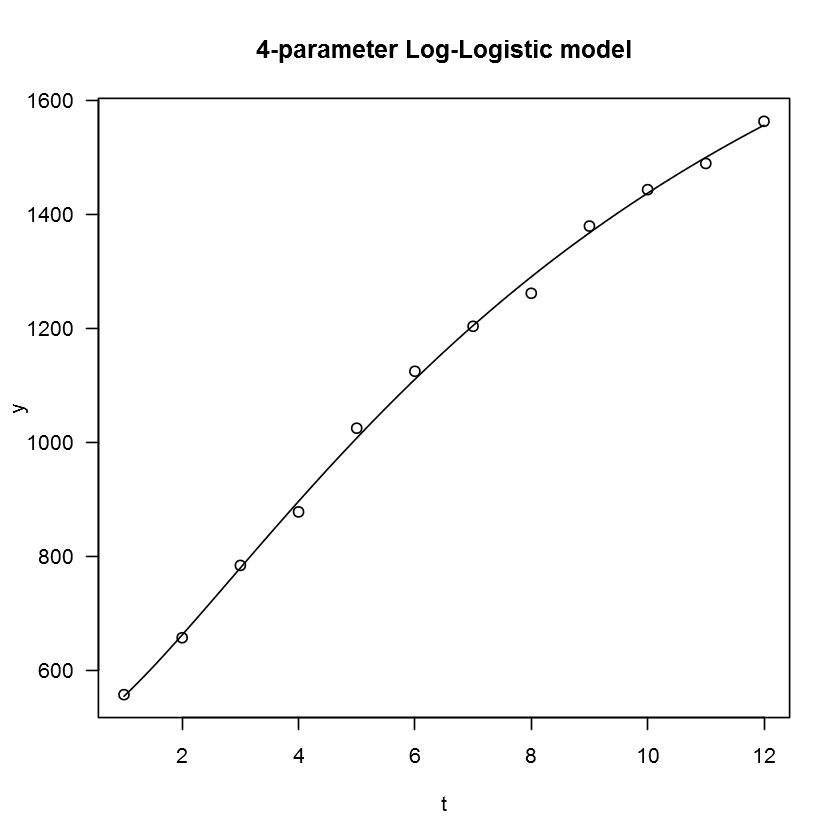

In [5]:
covid_can<-filter_ccaa_data(covid_full_data,"Canarias")
covid_can$var<-covid_can$casos
date_ref<-"2020-03-23"
covid_can<-covid_can[covid_can$date>=date_ref,]

data.COVDAT<-data.frame(date=covid_can$date,
                        t=seq_along(covid_can$var),
                        y=covid_can$var)

model.COVDAT <- drm(y ~ t, data  = data.COVDAT, fct=LL.4())

plot(model.COVDAT, log="", main = "4-parameter Log-Logistic model")
data.COVDAT$pred<-predict(model.COVDAT)


<a id='predict'></a>
### 4.1 Making predictions 

Function *pred.COVDAT()* provide us with predictions for the next days.

In [6]:
#Function to create a data.frame with estimates and intervals of prediction
pred.COVDAT <- function(model,data,idx) {
  options(warn=-1)
  cbind(
    data.frame(date=tail(data$date,1)+idx,
               t=tail(data$t,1)+idx,
               y=NA),
    predict(model, level=0.95,
            newdata=data.frame(t = tail(data$t,1)+idx), 
            interval = "prediction")
  )
}

A data.frame with the observed data is merged with the predictions of the next three days.

In [7]:
predict.COVDAT<-pred.COVDAT(model.COVDAT,data.COVDAT,1:3)
colnames(predict.COVDAT)[4:6]<-c("pred","lwr","upr")
data.COVDAT[,c("lwr", "upr")]<-NA
data.COVDAT<-rbind(data.COVDAT,predict.COVDAT)
head(data.COVDAT,13)


,date,t,y,pred,lwr,upr
,<date>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,2020-03-23,1,557,554.1099,NA,NA
2,2020-03-24,2,657,661.9105,NA,NA
3,2020-03-25,3,784,779.5124,NA,NA
4,2020-03-26,4,878,896.4446,NA,NA
5,2020-03-27,5,1025,1007.6410,NA,NA
6,2020-03-28,6,1125,1110.8077,NA,NA
7,2020-03-29,7,1204,1205.1695,NA,NA
8,2020-03-30,8,1262,1290.7738,NA,NA
9,2020-03-31,9,1380,1368.0904,NA,NA


<a id='plot'></a>
### 4.2 Table and plot of observed and predicted data

The following functions are built to represent in a chart the observed number of Covid-19 cases and the prediction for the next days.

In [8]:
#Function to plot observed and prediction data
plot_covid<-function(data,title,subtitle,legend,
                        xlabel="Día",
                        ylabel="Número de individuos",
                        caption="Fuente: Ministerio de Sanidad.",
                        datemin="2020-03-16",
                        breaks=100) {
  p<-ggplot(subset(data,date<=min(data$date[is.na(data$y)])), 
            mapping = aes(x = date, y = pred,color="red1") ) +   
    geom_line(size =1.25)+ 
    geom_line(subset(data,is.na(y)),mapping=aes(x=date,y=pred),inherit.aes = FALSE,color="blue",linetype="dashed")+ 
    geom_point(subset(data,is.na(y)),mapping=aes(x=date,y=pred),inherit.aes = FALSE,color="blue",size=2.1)+
    geom_ribbon(subset(data,is.na(y)),mapping=aes(x=date,ymin=lwr,ymax=upr),inherit.aes = FALSE,
                color="blue",alpha=0.3)+
    geom_point(subset(data,date>=datemin),
               mapping=aes(x=date,y=y),inherit.aes = FALSE,size=2.1)+
    scale_color_manual( values = "red1",labels = legend)+ 
    theme(
      plot.title = element_text(size = 24, face = "bold",hjust = 0.5),
      plot.subtitle = element_text(size = 18,hjust = 0.5),
      plot.caption = element_text(size = 12, face = "italic"),
      legend.position="top",
      legend.title = element_blank(),
      legend.box = "horizontal" ,
      legend.text=element_text(size=14),
      panel.grid.minor = element_blank(), 
      panel.grid.major = element_line(color = "gray50", size = 1.0),
      panel.grid.major.x = element_blank(),
      panel.background = element_blank(),
      line = element_blank(),
      axis.ticks.length = unit(.15, "cm"),
      axis.ticks.y = element_blank(),
      axis.title.x = element_text(color="black", 
                                  size=18),
      axis.title.y = element_text(color="black",
                                  size=18),
      axis.text.x = element_text(angle = -90, hjust = 1, size=14),
      axis.text.y = element_text(size=14) )+
    
    scale_y_continuous(expand = c(0, 0),
                       limits=c(0.0,plyr::round_any(max(data$upr,na.rm=TRUE), breaks, f = ceiling)),
                       breaks=seq(0.0,plyr::round_any(max(data$upr,na.rm=TRUE), breaks, f = ceiling),breaks), labels = scales::comma,
                       name = xlabel)+
    
    scale_x_date(expand=c(0.01,0),
                 date_breaks="1 days",
                 date_labels = "%d/%m/%Y",name = ylabel) +
    
    labs(title = title, 
         subtitle=subtitle,
         caption = caption
    )
  p
  
}

#Function to annotate the table with prediction estimates
annotate_estim_plot_covid<-function(plotchart,data,date,ypos) {
  plotchart+annotation_custom(
    grob = data %>% filter(is.na(y)) %>% dplyr::select(date,lwr,pred,upr) %>% 
      dplyr::mutate(lwr=round(lwr, digits = 1),
                    pred=round(pred, digits = 1),
                    upr=round(upr, digits = 1)) %>%
      dplyr::rename("Fecha"=date,"Min."=lwr,"Estimación"=pred,"Max."=upr) %>% tableGrob(rows = NULL, theme=ttheme_default(core = list(fg_params=list(cex = 1.5)))),
    xmin = as.Date(date),
    xmax = as.Date(date)+6,
    ymin = ypos
    ) 
}

#Function to annotate relevant dates
annotate_date_plot_covid<-function(plotchart,label,date,ypos) {
  plotchart+geom_vline(xintercept = as.Date(date), linetype="dashed", 
                       color = "blue", size=1.2)+
    annotate(geom="text", x=as.Date(date)+0.1, y=ypos, label=label,color="black",hjust = 0, size=6)
  
}

We represent the data with the corresponding prediction bands, and we remark a particular day event of our interest

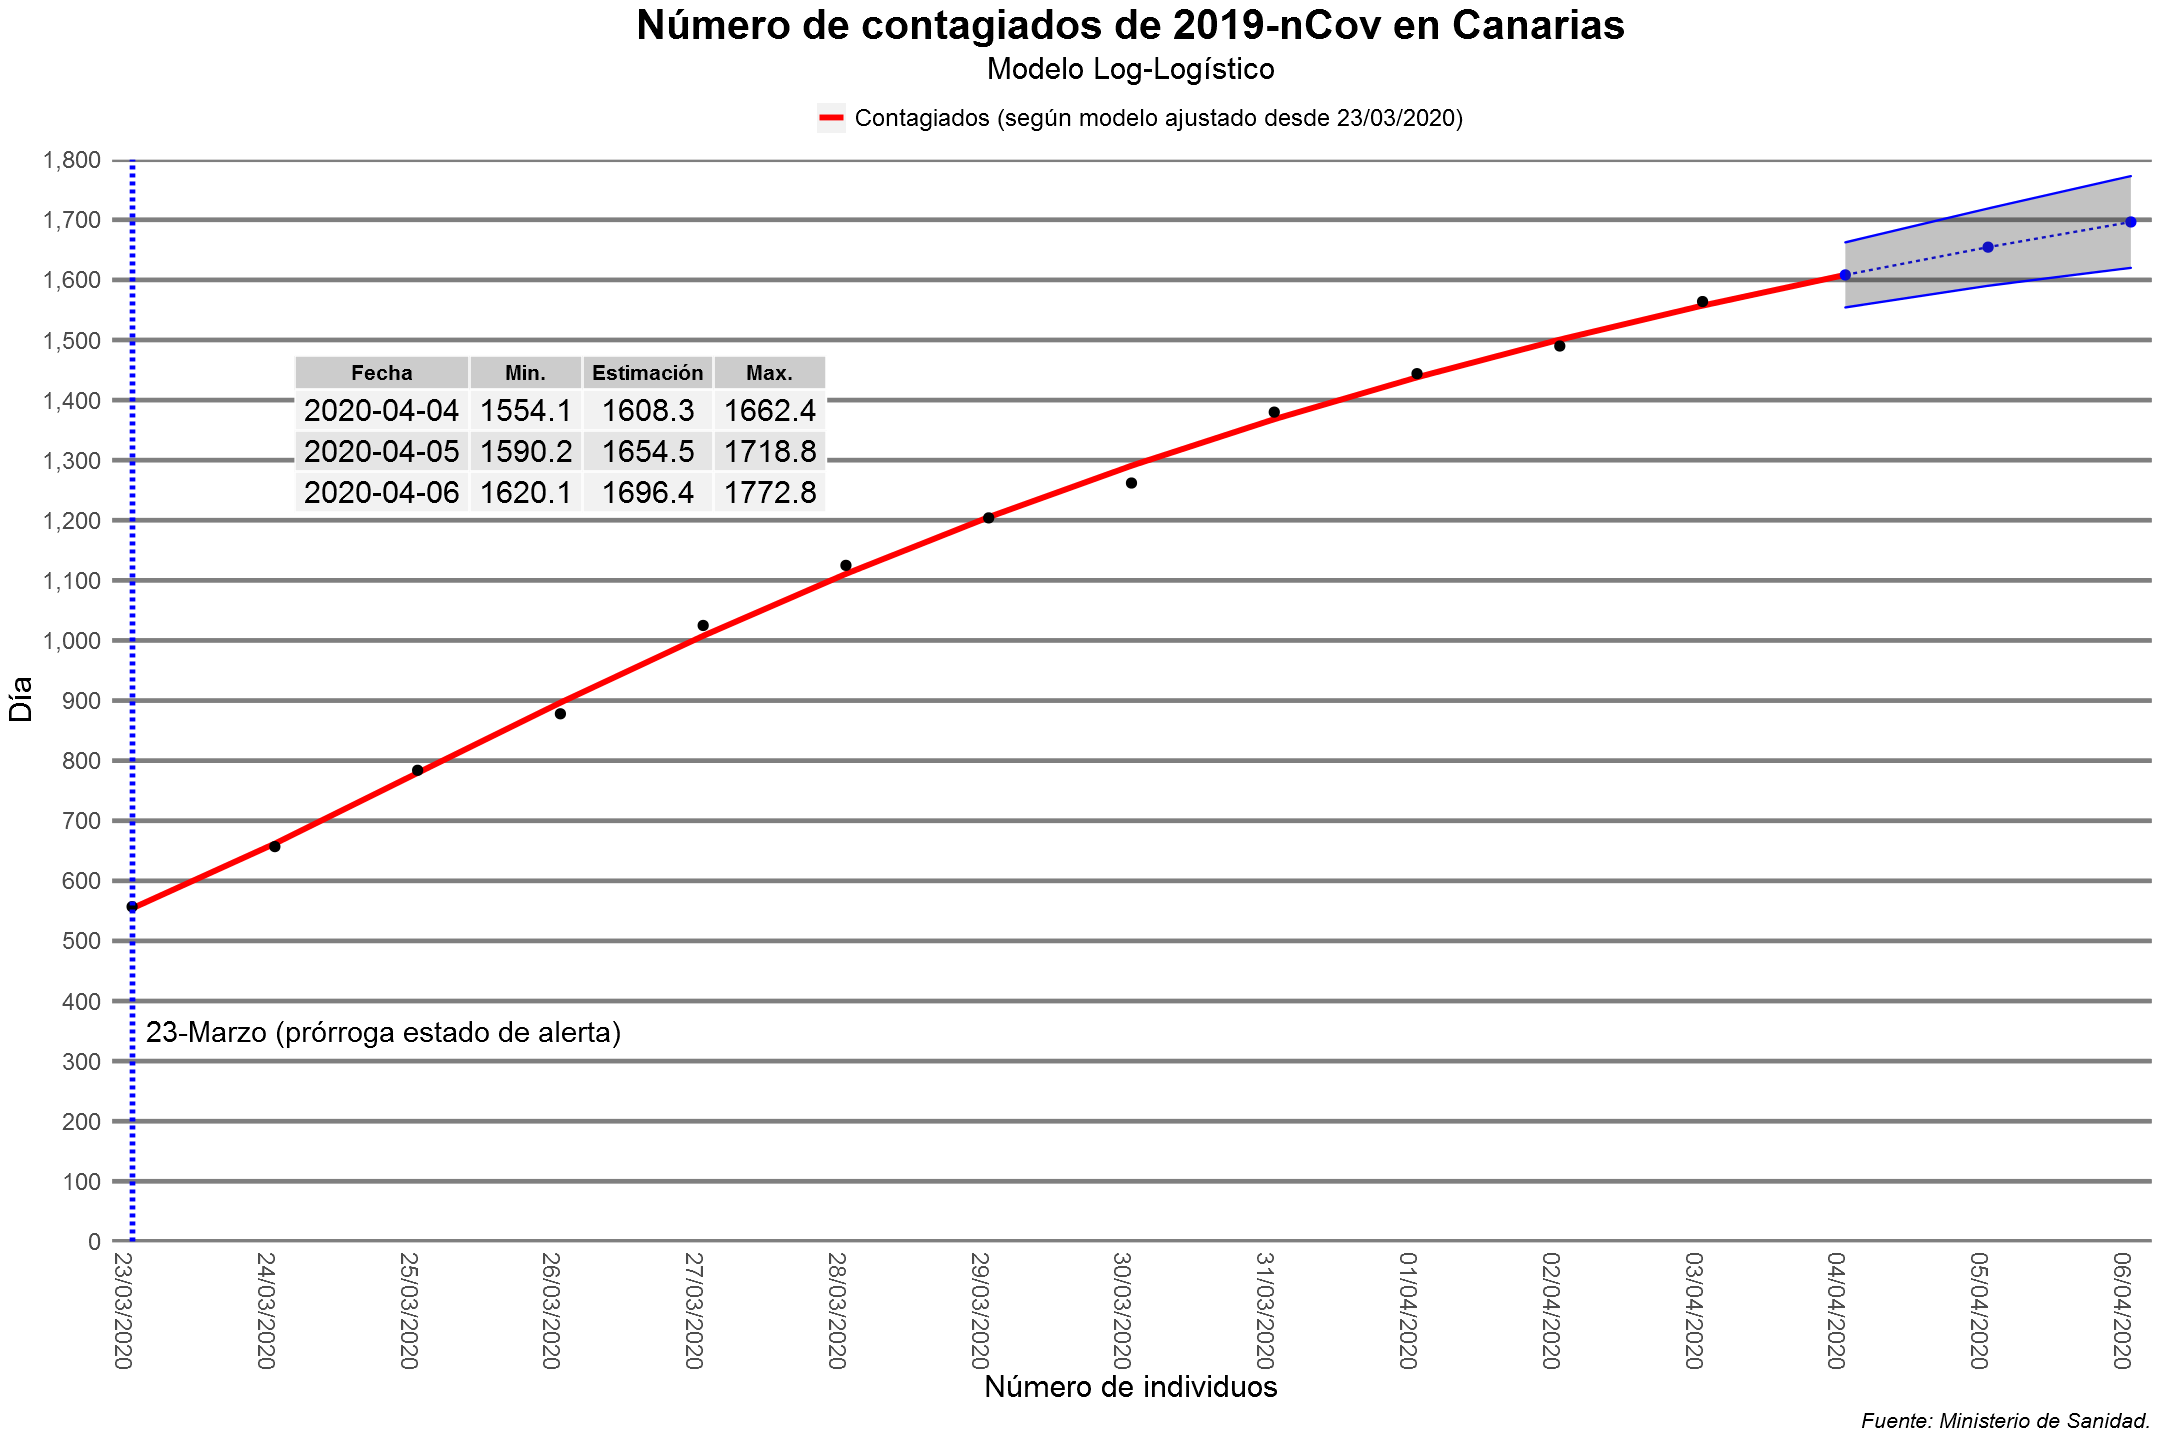

In [9]:
options(repr.plot.width=18, repr.plot.height=12)
plot.COVDAT<-plot_covid(data.COVDAT,
                        title="Número de contagiados de 2019-nCov en Canarias",
                        subtitle="Modelo Log-Logístico",
                        legend="Contagiados (según modelo ajustado desde 23/03/2020)",
                        xlabel="Día",
                        ylabel="Número de individuos",
                        caption="Fuente: Ministerio de Sanidad.")

plot.COVDAT %>% annotate_date_plot_covid(label="23-Marzo (prórroga estado de alerta)",
                                         date="2020-03-23",ypos=350) %>% 
                annotate_estim_plot_covid(data.COVDAT,
                                          date="2020-03-23", 
                                          ypos=data.COVDAT$upr[nrow(data.COVDAT)]/2)


<a id='hospitalized'></a>
### 4.3 Predicting the hospitalized patients

The same methodology can be applied to predict the number of hospitalized patients (or the recovered people). We illustrate this modelling in the following

In [10]:
covid_can<-filter_ccaa_data(covid_full_data,"Canarias")
covid_can$var<-covid_can$hospitalizados
date_ref<-"2020-03-23"
covid_can<-covid_can[covid_can$date>=date_ref,]

data.COVDAT<-data.frame(date=covid_can$date,
                        t=seq_along(covid_can$var),
                        y=covid_can$var)
model.COVDAT <- drm(y ~ t, data  = data.COVDAT, fct=LL.4())
data.COVDAT$pred<-predict(model.COVDAT)
predict.COVDAT<-pred.COVDAT(model.COVDAT,data.COVDAT,1:3)
colnames(predict.COVDAT)[4:6]<-c("pred","lwr","upr")
data.COVDAT[,c("lwr", "upr")]<-NA
data.COVDAT<-rbind(data.COVDAT,predict.COVDAT)

A plot for the observed and prediction data is provided in a similar way to the infected cases.


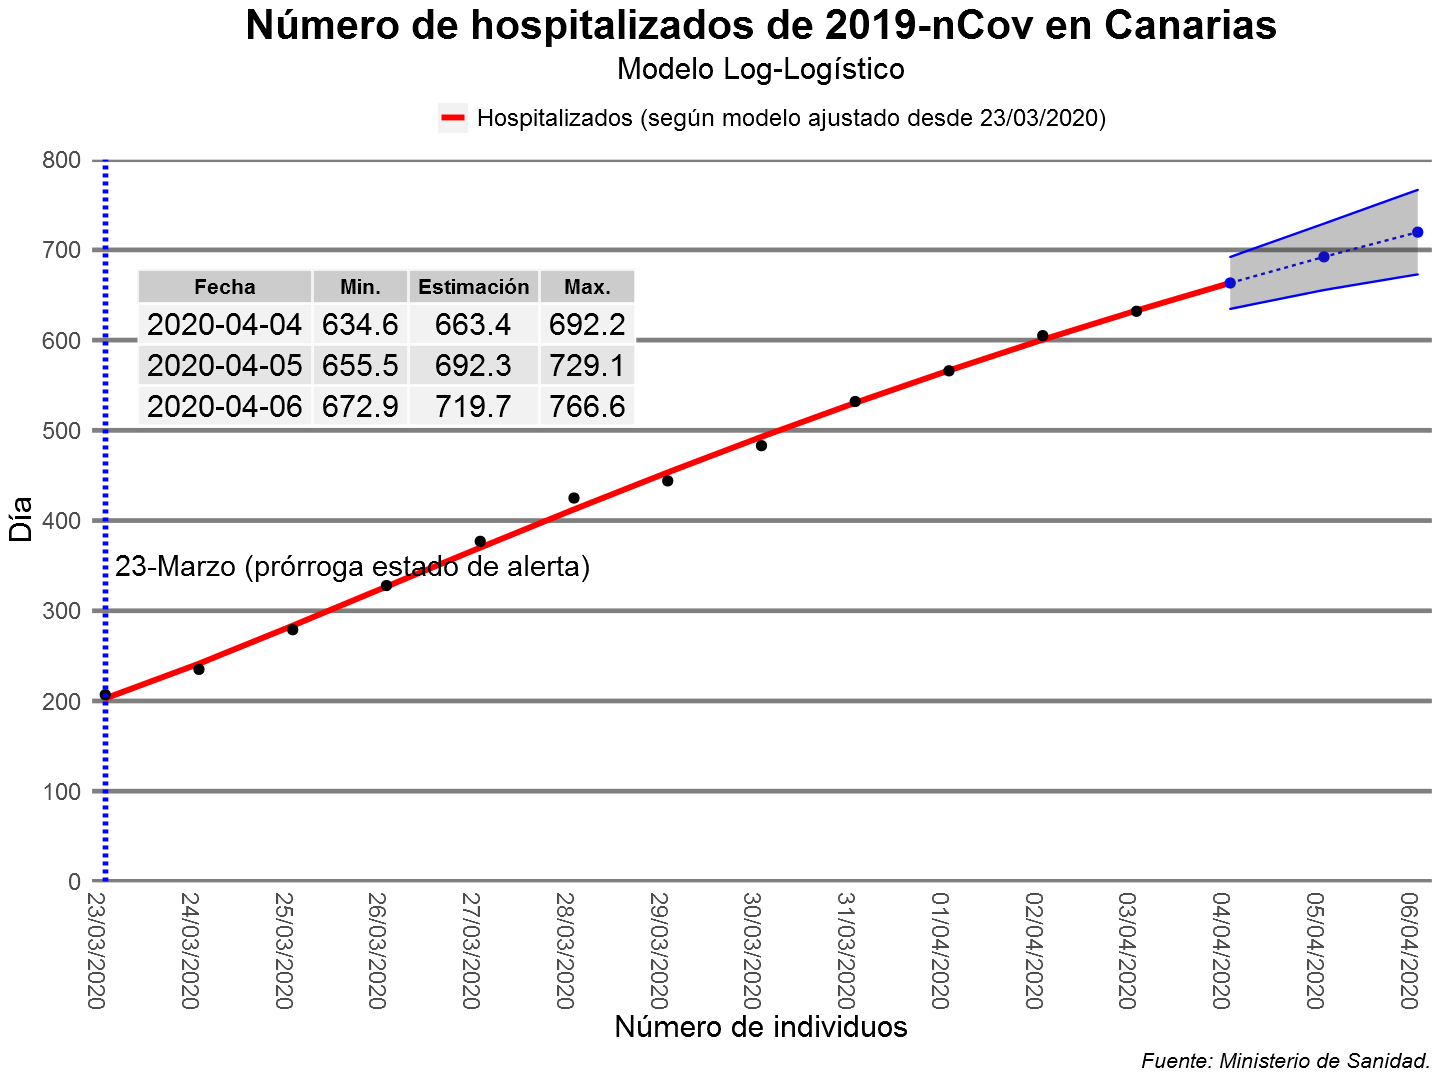

In [11]:
options(repr.plot.width=12, repr.plot.height=9)
plot.COVDAT<-plot_covid(data.COVDAT,
                        title="Número de hospitalizados de 2019-nCov en Canarias",
                        subtitle="Modelo Log-Logístico",
                        legend="Hospitalizados (según modelo ajustado desde 23/03/2020)",
                        xlabel="Día",
                        ylabel="Número de individuos",
                        caption="Fuente: Ministerio de Sanidad.")

plot.COVDAT %>% annotate_date_plot_covid(label="23-Marzo (prórroga estado de alerta)",
                                         date="2020-03-23",ypos=350) %>% 
                annotate_estim_plot_covid(data.COVDAT,
                                          date="2020-03-23",ypos=data.COVDAT$upr[nrow(data.COVDAT)]/2)

<a id='cite'></a>
## 5. How to cite this work

Feel free to use the code and content of this notebook for your own contributions. In this case, please consider citing our Zenodo record:

Carlos Pérez-González, Arturo Fernández Rodríguez, & Roberto Dorta Guerra. (2020, April 2). ULL-STAT/covid19_model: First version of Covid19-Prediction outbreak notebook (Version v1.0.1). Zenodo. http://doi.org/10.5281/zenodo.3737192

<a id='references'></a>
## 6. References

<a id='Seber'></a> [1] Seber, G. A. F. and Wild, C. J (1989) Nonlinear Regression, New York: Wiley & Sons.

<a id='Malato'></a> [2] Malato. G. (2020, March 8). [Covid-19 infection in Italy. Mathematical models and predictions. A comparison of logistic and exponential models applied to Covid-19 virus infection in Italy](https://towardsdatascience.com/covid-19-infection-in-italy-mathematical-models-and-predictions-7784b4d7dd8d). Medium: Towards Data Science. 
